In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [3]:
# price is a factor for our company, so we're going to use a low cost model

# MODEL = "gpt-4o-mini"
from openai import OpenAI
MODEL = "llama3.2"
openai = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")
db_name = "vector_db"

In [4]:
# Load environment variables in a file called .env

# load_dotenv(override=True)
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders
folders = glob.glob("knowledge-base/*")

text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [7]:
len(chunks)

123

In [8]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: contracts, products, company, employees


In [9]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk

# embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

C:\Users\dasha\AppData\Local\Temp\ipykernel_35636\1687908394.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [10]:
# Check if a Chroma Datastore already exists - if so, delete the collection to start from scratch

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [11]:
# Create our Chroma vectorstore!

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [12]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 384 dimensions


***Visualizing the Vector Store**


This code snippet processes data retrieved from a collection object, likely from a vector database like Chroma. Let's break it down:

result = collection.get(include=['embeddings', 'documents', 'metadatas']): This line retrieves data from the collection.
.get() is a method to retrieve data.
include=['embeddings', 'documents', 'metadatas'] specifies which fields to retrieve for each item in the collection. It asks for the vector embeddings, the original document text, and any associated metadata.
vectors = np.array(result['embeddings']): This line extracts the 'embeddings' from the result dictionary and converts them into a NumPy array. Embeddings are numerical representations of the documents, often used for similarity search or visualization.
documents = result['documents']: This line extracts the 'documents' (the original text content) from the result dictionary and assigns them to the documents variable.
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]: This is a list comprehension that extracts the 'doc_type' from the 'metadatas' list within the result dictionary. It creates a new list called doc_types containing just the type of each document (e.g., 'products', 'employees', 'contracts', 'company').
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]: This line assigns a color to each document based on its doc_type.
It iterates through the doc_types list.
For each document type t, it finds the index of t in the list ['products', 'employees', 'contracts', 'company'].
It then uses that index to select a corresponding color from the list ['blue', 'green', 'red', 'orange'].
The resulting list of colors is assigned to the colors variable. This is likely done to visualize the documents on a plot, where each document type is represented by a different color.
In summary, this code retrieves embeddings, documents, and metadata from a collection, extracts the document types, and then creates a list of colors based on these document types for potential visualization.

In [15]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

This code snippet visualizes the vector embeddings of documents in a 2D scatter plot using t-SNE for dimensionality reduction and Plotly for interactive plotting. Let's break it down:

tsne = TSNE(n_components=2, random_state=42): This initializes a t-SNE object.
TSNE is a dimensionality reduction technique particularly good at visualizing high-dimensional data in a low-dimensional space (like 2D or 3D) while preserving local relationships between data points.
n_components=2 specifies that we want to reduce the data to 2 dimensions.
random_state=42 ensures reproducibility of the t-SNE results.
reduced_vectors = tsne.fit_transform(vectors): This applies the t-SNE transformation to the vectors (which are presumably the high-dimensional vector embeddings of the documents).
fit_transform() fits the t-SNE model to the data and then transforms the data to the specified number of components (2 in this case).
The result, reduced_vectors, is a NumPy array where each row represents a document and the two columns are its coordinates in the 2D space.
fig = go.Figure(data=[go.Scatter(...)]): This creates a Plotly figure object.
go.Figure() is the constructor for a Plotly figure.
data=[go.Scatter(...)] specifies the data to be plotted. In this case, it's a single scatter plot trace.
go.Scatter(...): This defines the scatter plot trace.
x=reduced_vectors[:, 0] sets the x-coordinates of the points to the first column of reduced_vectors.
y=reduced_vectors[:, 1] sets the y-coordinates of the points to the second column of reduced_vectors.
mode='markers' specifies that the plot should use markers (dots) to represent the data points.
marker=dict(...) configures the appearance of the markers.
size=5 sets the size of the markers.
color=colors sets the color of each marker based on the colors list (which was likely generated based on document types in a previous step).
opacity=0.8 sets the transparency of the markers.
text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)] sets the text that appears when you hover over a data point. It combines the document type and the first 100 characters of the document text. <br> creates a line break in the hover text.
hoverinfo='text' specifies that only the custom text should be displayed on hover.
fig.update_layout(...): This updates the layout of the figure.
title='2D Chroma Vector Store Visualization' sets the title of the plot.
scene=dict(xaxis_title='x',yaxis_title='y') sets the titles for the x and y axes. Although this is a 2D plot, scene is sometimes used with scatter plots in Plotly for more advanced configurations.
width=800 and height=600 set the dimensions of the plot.
margin=dict(r=20, b=10, l=10, t=40) sets the margins around the plot.
fig.show(): This displays the generated Plotly figure.
In summary, this code takes high-dimensional vector embeddings, reduces them to 2 dimensions using t-SNE, and then creates an interactive scatter plot using Plotly to visualize these reduced vectors. The points are colored by document type, and hovering over a point shows information about the original document.

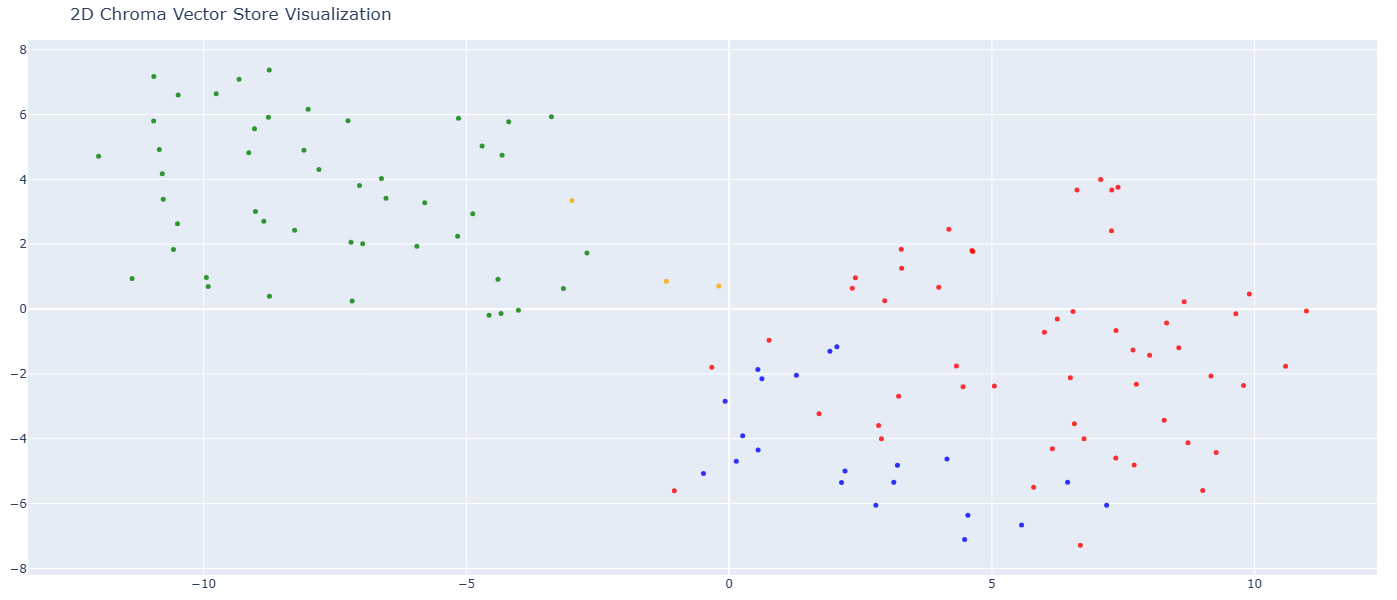

In [19]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

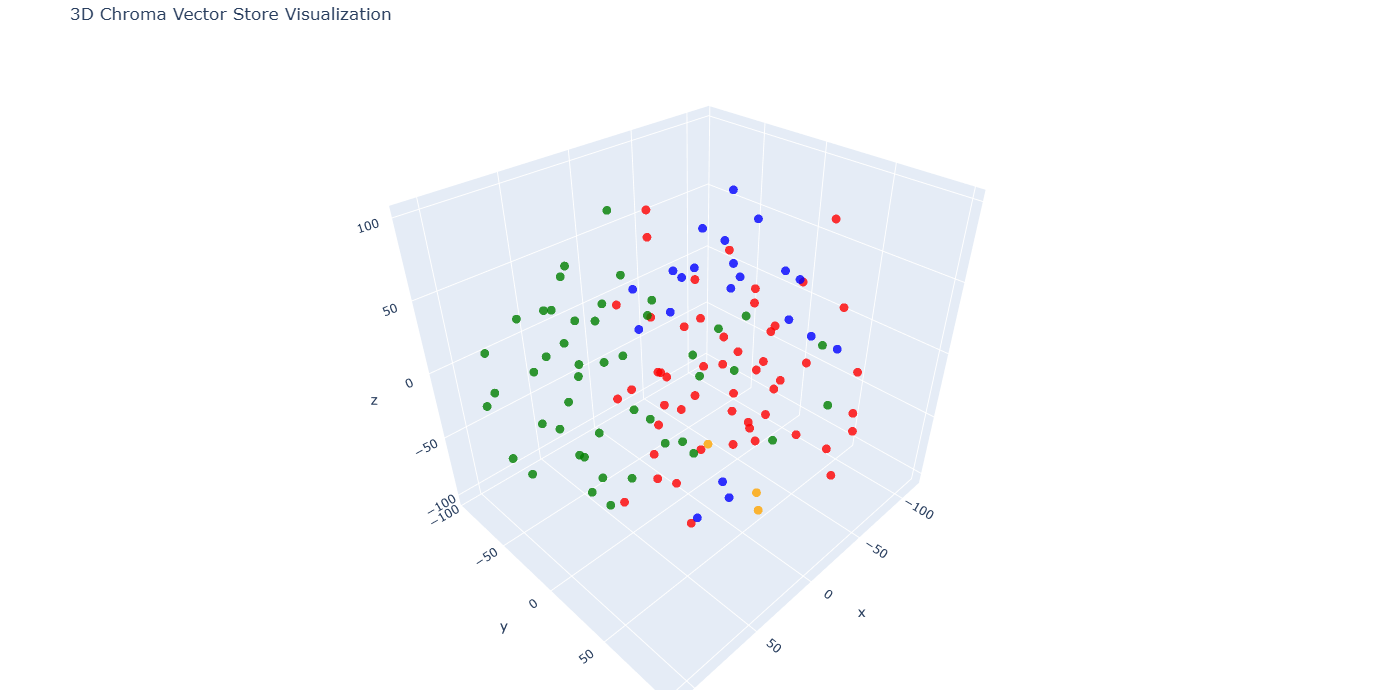

In [20]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()